Import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile
import os
from sklearn import set_config
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

### Load Dataset

Load and extract the dataset in data variable.

In [2]:
data = pd.read_csv("../customerchurn_dataset/Telco-Customer-Churn.csv")

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")

Rows: 7043, Columns: 21


In [6]:
print(data.isnull().values.any())
print(data.isnull().sum())

False
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
print(data.duplicated().sum())

0


In [8]:
data_copy = data.copy()

customerID is not significant to our classification, so drop it. Also create a copy of the original data to work with.

In [9]:
data_copy= data_copy.drop(columns=["customerID"])

### EDA & Preprocessing

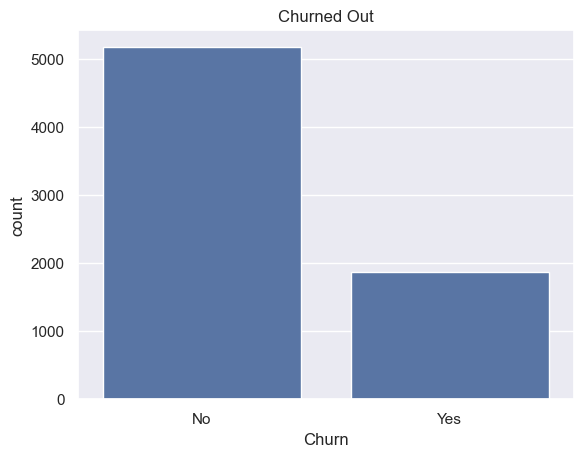

In [10]:
sns.countplot(x="Churn",data= data_copy)
plt.title("Churned Out")
plt.show()

Create two lists, one for object data type columns and other for numerical data type columns. This helps to classify the different data types present in the data to each list, which will be useful further.

In [11]:
obj_cols= []
for col in data_copy.columns:
    if data_copy[col].dtype=='object':
        obj_cols.append(col)
num_cols= []
for col in data_copy.columns:
    if data_copy[col].dtype!='object':
        num_cols.append(col)
print(f"Object columns: {obj_cols}\n")
print(f"Numerical columns: {num_cols}")

Object columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']

Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


In [12]:
data_copy["TotalCharges"]= pd.to_numeric(data_copy["TotalCharges"], errors= 'coerce')
data_copy["TotalCharges"]= data_copy["TotalCharges"].fillna(0)
obj_cols.remove('TotalCharges')
num_cols.append('TotalCharges')

Let us list down all the unique values in the categorical columns of our dataset.

In [13]:
for col in obj_cols:
    print(f"Unique values in {col} are {data_copy[col].unique()}\n")


Unique values in gender are ['Female' 'Male']

Unique values in Partner are ['Yes' 'No']

Unique values in Dependents are ['No' 'Yes']

Unique values in PhoneService are ['No' 'Yes']

Unique values in MultipleLines are ['No phone service' 'No' 'Yes']

Unique values in InternetService are ['DSL' 'Fiber optic' 'No']

Unique values in OnlineSecurity are ['No' 'Yes' 'No internet service']

Unique values in OnlineBackup are ['Yes' 'No' 'No internet service']

Unique values in DeviceProtection are ['No' 'Yes' 'No internet service']

Unique values in TechSupport are ['No' 'Yes' 'No internet service']

Unique values in StreamingTV are ['No' 'Yes' 'No internet service']

Unique values in StreamingMovies are ['No' 'Yes' 'No internet service']

Unique values in Contract are ['Month-to-month' 'One year' 'Two year']

Unique values in PaperlessBilling are ['Yes' 'No']

Unique values in PaymentMethod are ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Uniqu

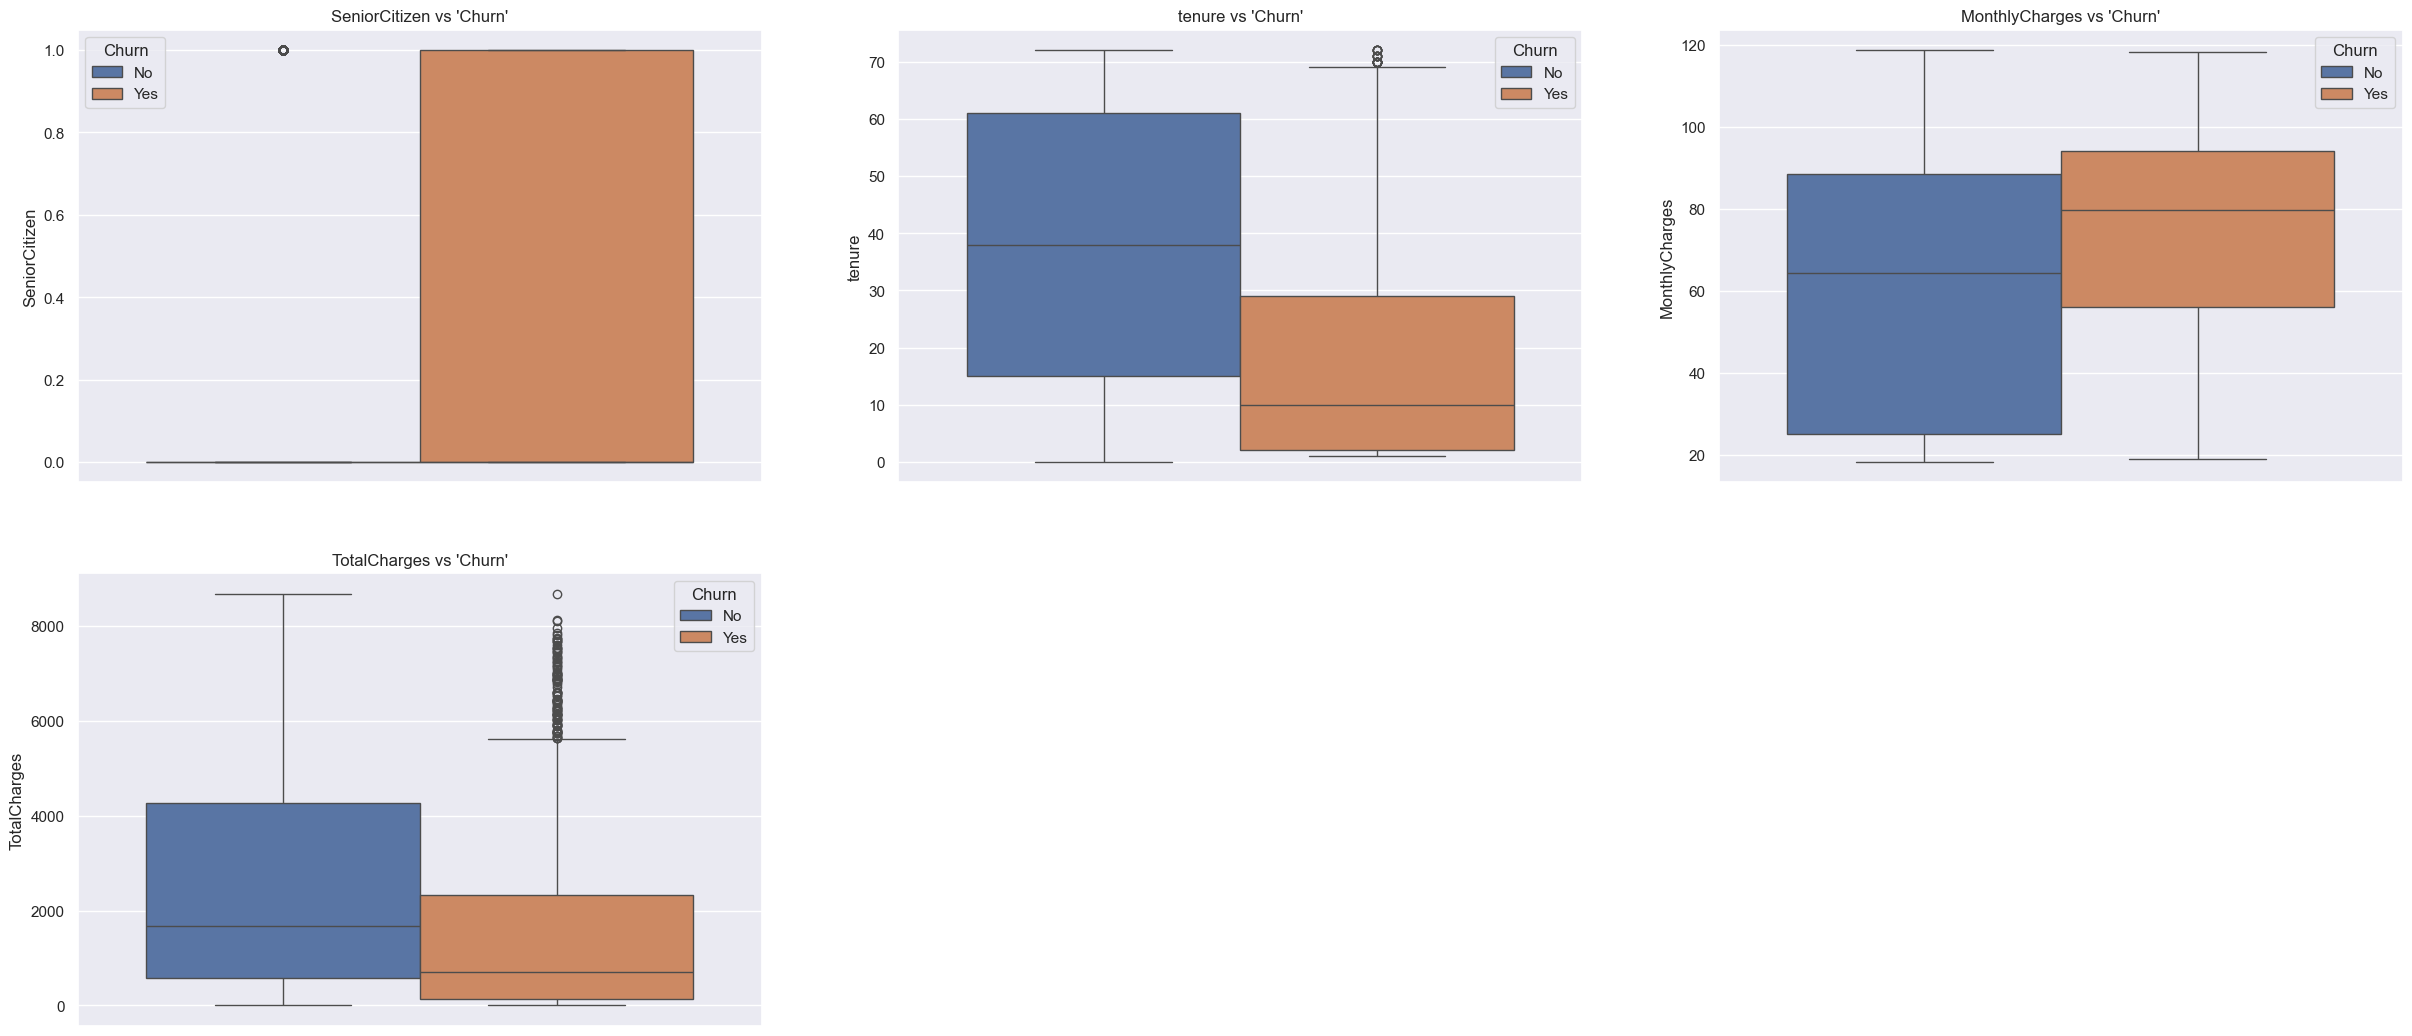

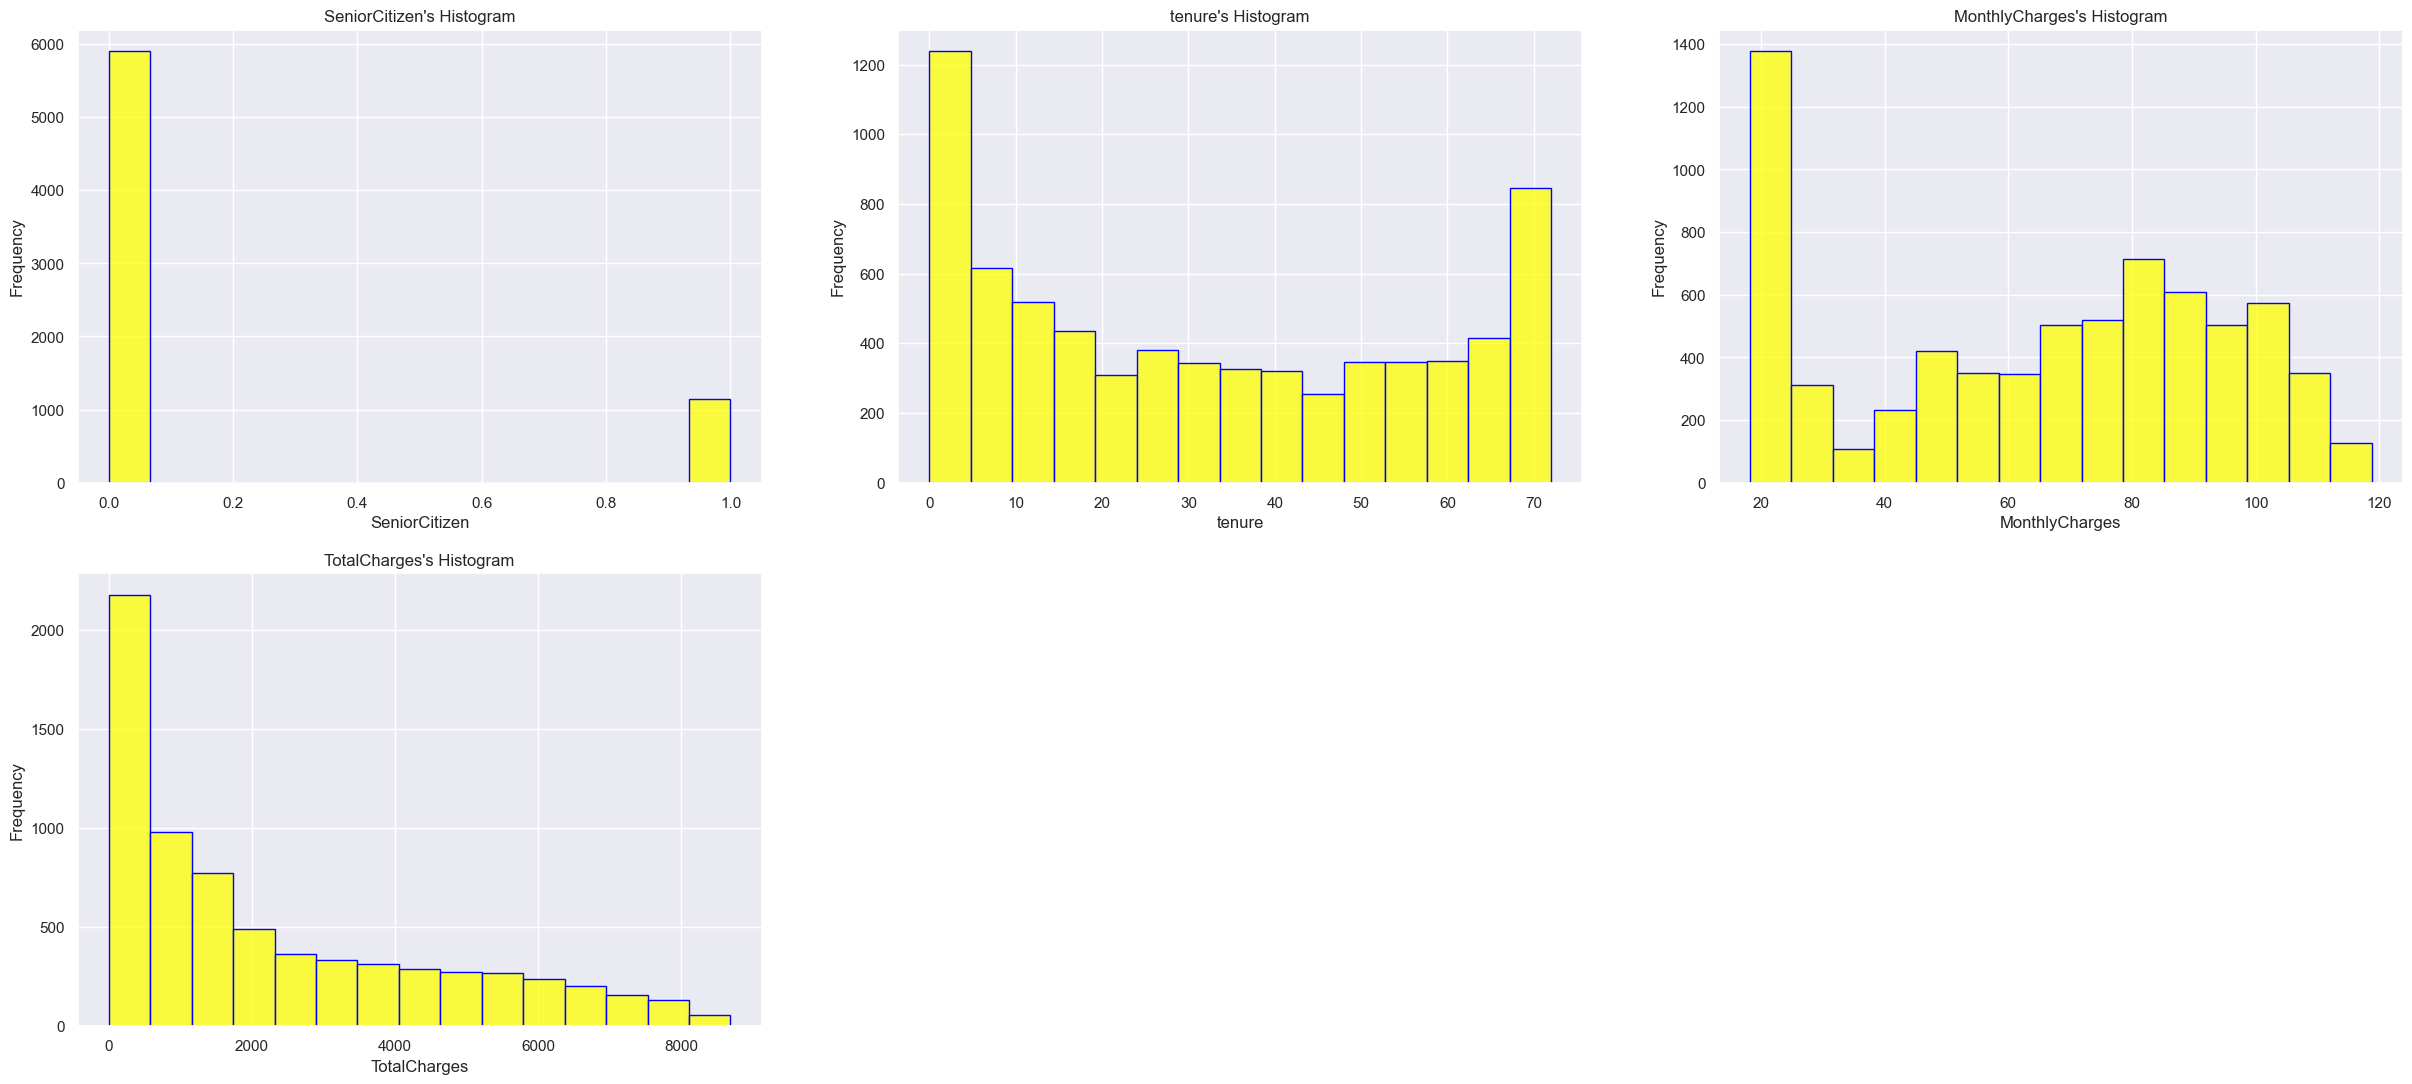

In [14]:
plt.figure(figsize=(30, 20))
for i,col in enumerate(num_cols,start= 1):
    plt.subplot(3,3,i)
    sns.boxplot(data= data_copy, hue= "Churn",y = col)
    plt.title(f"{col} vs 'Churn'")
plt.show()

plt.figure(figsize=(30, 20))
for i,col in enumerate(num_cols,start= 1):
    plt.subplot(3,3,i)
    sns.histplot(data= data_copy, x= data_copy[col], bins= 15, color= 'yellow', edgecolor= 'blue')
    plt.ylabel("Frequency")
    plt.title(f"{col}'s Histogram")
plt.show()

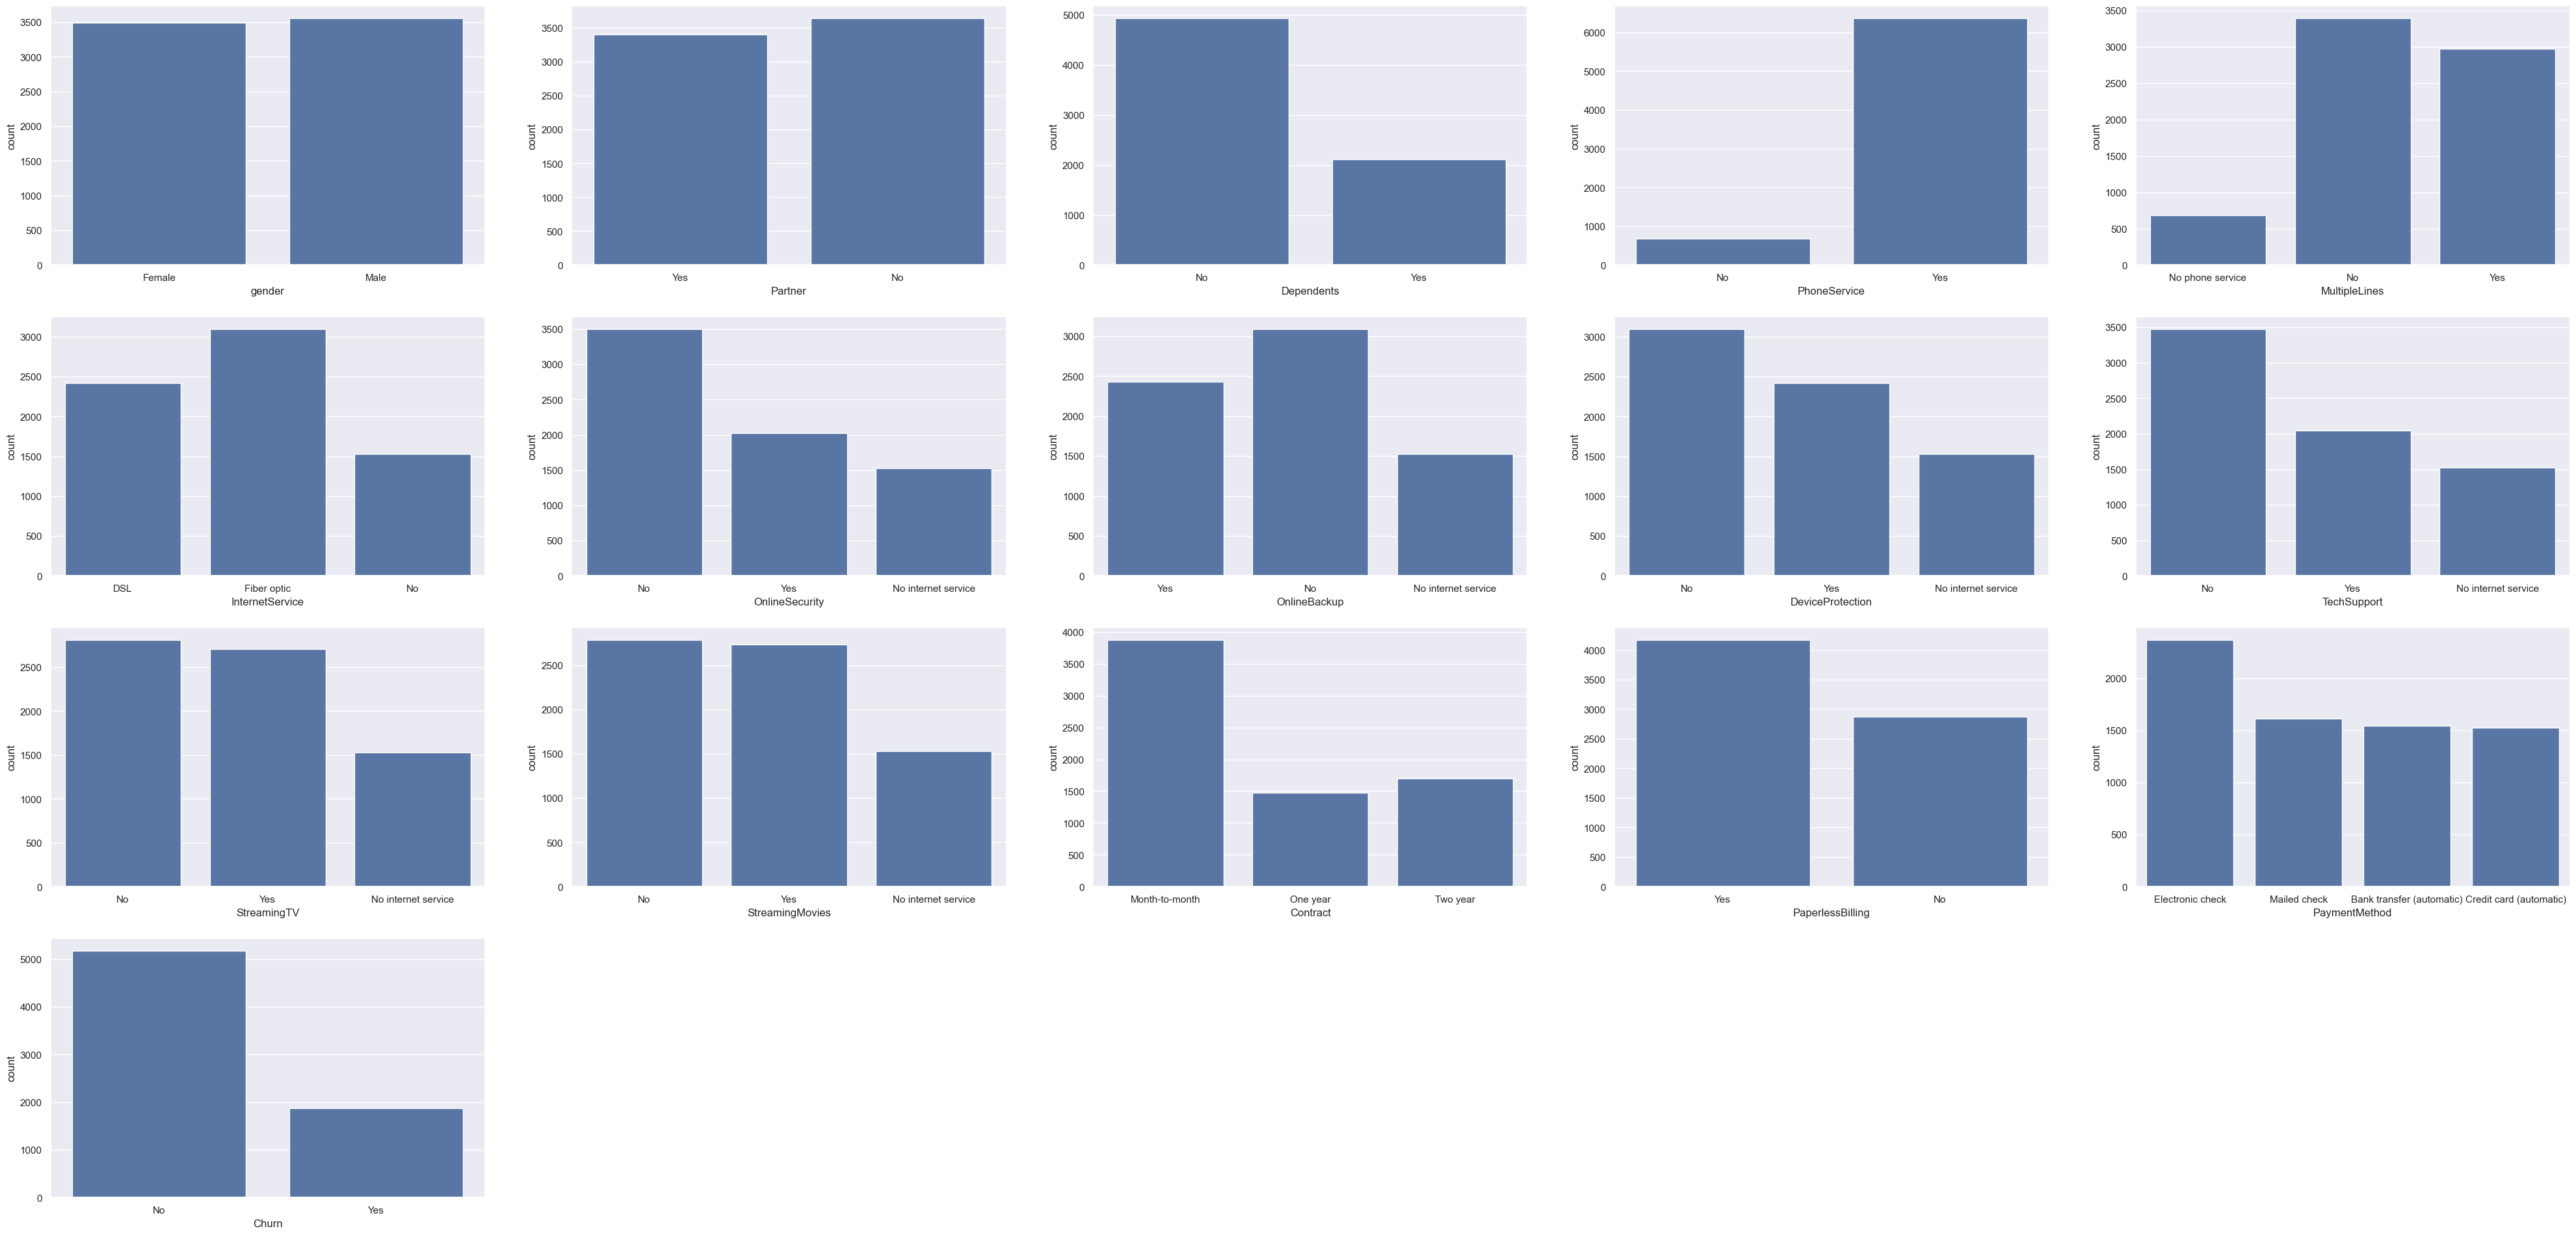

In [15]:
plt.figure(figsize=(50,30))
for i,col in enumerate(obj_cols, start=1):
    plt.subplot(5,5,i)
    sns.countplot(x=col,data= data_copy)
plt.show()

Create a correlation heatmap or clustermap to help identify the relations between different features.

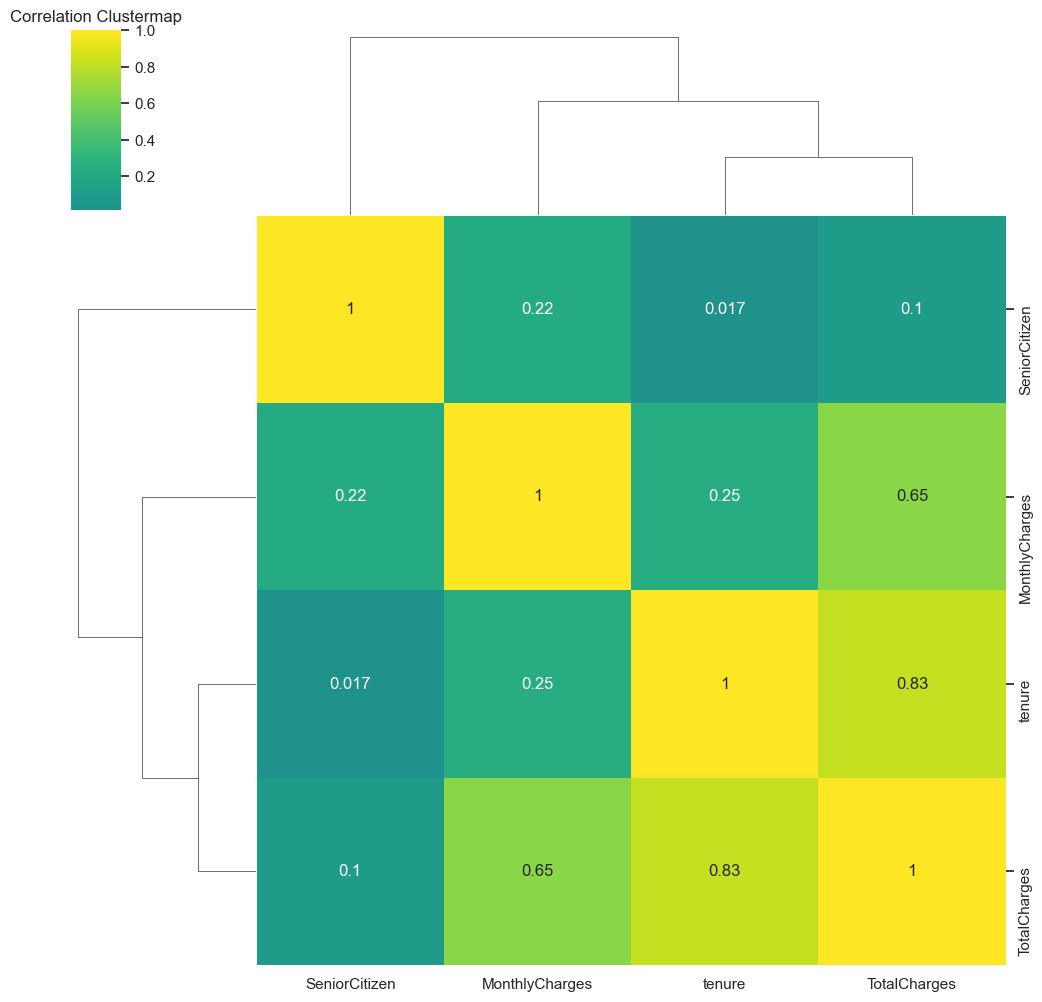

In [16]:
num_data= data_copy[num_cols]
corr_matrix = num_data.corr()
sns.clustermap(corr_matrix, annot=True, center=0, cmap="viridis",figsize= (10,10))
plt.title("Correlation Clustermap")
plt.show()

Using One-Hot encoding for categorical columns and Scaling for numerical columns.

In [17]:
obj_cols.remove("Churn")
preprocessor= ColumnTransformer([ ("num", StandardScaler(), num_cols), ("categorical", OneHotEncoder(), obj_cols)])
data_copy["Churn"]= data_copy["Churn"].map({"No": 0, "Yes": 1}).astype(int)

## Variables

In [18]:
y = data_copy["Churn"]
X = data_copy.drop(columns = ["Churn"], axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 7, stratify= y)

## Model

In [20]:
rf_steps= [("preprocessor", preprocessor), ("smote_resample", SMOTE(random_state= 7)), ("classifier", RandomForestClassifier(class_weight='balanced', random_state= 7))]
rf_pipe= Pipeline(rf_steps)
set_config(display='diagram')
rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('smote_resample', SMOTE(random_state=7)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=7))])

In [21]:
params= {
        "classifier__max_depth": randint(20, 100),
        "classifier__max_features": ['sqrt', 'log2'],
        "classifier__max_leaf_nodes": randint(100, 500),
        "classifier__min_samples_leaf": randint(2, 20),
        "classifier__n_estimators": randint(50, 400),
        "classifier__min_samples_split": randint(2, 20),
        "classifier__criterion": ['gini', 'entropy']
        }

random_search= RandomizedSearchCV(rf_pipe, param_distributions=params, n_iter=100, scoring='roc_auc', cv=10, n_jobs=-1, random_state=7)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['SeniorCitizen',
                                                                                'tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges']),
                                                                              ('categorical',
                                                                               OneHotEncoder(),
                                                                               ['gender',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'PhoneService',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'Te...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000184D502BC50>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000184D4B676F0>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000184D4B67100>},
                   random_state=7, scoring='roc_auc')

In [22]:
random_search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 70,
 'classifier__max_features': 'log2',
 'classifier__max_leaf_nodes': 482,
 'classifier__min_samples_leaf': 19,
 'classifier__min_samples_split': 3,
 'classifier__n_estimators': 314}

In [23]:
rf_pipe= random_search.best_estimator_
rf_pipe.fit(X_train, y_train)
preds_rf= rf_pipe.predict(X_test)

In [24]:
print(f"Accuracy Score:{round(accuracy_score(y_test, preds_rf)*100, 2)}%")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, preds_rf)}")
print(f"Classification Report:\n {classification_report(y_test, preds_rf)}")
print(f" ROC_AUC:\n{roc_auc_score(y_test, rf_pipe.predict_proba(X_test)[:,1])}")

Accuracy Score:79.28%
Confusion Matrix:
 [[847 188]
 [104 270]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      1035
           1       0.59      0.72      0.65       374

    accuracy                           0.79      1409
   macro avg       0.74      0.77      0.75      1409
weighted avg       0.81      0.79      0.80      1409

 ROC_AUC:
0.8557402671213413
